### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`

In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

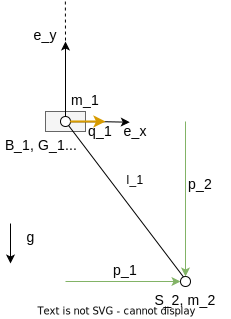

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_single_crane_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 2 # number of passive coordinates (not directly actuated) -> x_load, y_load
nq = 1 # number of actuated coordinates -> x_1
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(2+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('m1, m2, l1, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2 = ttau = st.symb_vector("tau1, tau2")


Specify the geometry (joints G and centers of masses S)

---

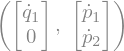

---

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# Time derivatives of centers of masses
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##:

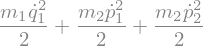

---

---

In [6]:
# kinetic energy
T1 = (m1/2 * Sd1.T*Sd1)[0] 
T2 = (m2/2 * Sd2.T*Sd2)[0]

T = T1 + T2 ##:

# potential energy
V = m2*g*S2[1] ##:

this model is very easy ...

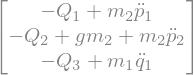

In [7]:
mod = mt.generate_symbolic_model(T, V, ttheta, QQ)
mod.eqns

... but $Q_i$ are yet unknown → calculate them via the principle of virtual work, see e.g. [Wikipedia](https://en.wikipedia.org/wiki/Generalized_forces#Virtual_work):
$$
\delta W = \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_1} \delta q_1 +\ldots + \sum_{i=1}^n \mathbf {F}_{i} \cdot \frac {\partial \mathbf {r}_i} {\partial q_m} \delta q_m.
$$

- $ \mathbf {F}_{i}$ applied forces, i.e.  $i=1,2$ → cart-forces, $i=3,4$ → rope-foces
- $ \mathbf {r}_{i}$ position vectors of each particle (along the direction of forces): $i=1,3$ → cart, $i=2$ → load
- $ \mathbf {\delta r}_{i}$ virtual displacement
- $ \mathbf \delta q_{j} = \delta \theta_{j}$ virtual displacement of generalized coordinates


The virtual work of a system of particles can be written in the form

$$
    \delta W = Q_1\delta q_1 + \ldots + Q_m\delta q_m,
$$
where

$$
    Q_j = \sum_{i=1}^n \frac {\partial \mathbf {r}_i} {\partial q_j} \cdot \mathbf {F}_{i}  ,\quad j=1,\ldots, m, 
$$

---

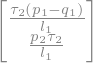

---

In [8]:
F1 = sp.Matrix([tau1, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope = (S2 - S1)

uv_rope = rope/sp.sqrt((rope.T*rope)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope = rope/l1

F2 = uv_rope * tau2 ##:

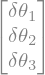

---

In [9]:
dt1, dt2, dt3 = ddelta_theta = st.symb_vector(f"\\delta\\theta_1:{n+1}") ##:

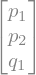

In [10]:
ttheta

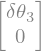

---

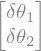

---

In [11]:
delta_S1 = S1*0
delta_S2 = S2*0

for theta, delta_theta in zip(ttheta, ddelta_theta):
    
    delta_S1 += S1.diff(theta)*delta_theta
    delta_S2 += S2.diff(theta)*delta_theta
    
delta_S1 ##:
delta_S2 ##:

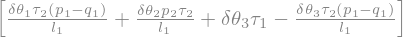

---

In [12]:
# simple part (cart)
delta_W = delta_S1.T*F1

# rope (F2 > 0 means rope is pushing from S1 towards S2)
delta_W = delta_W + delta_S2.T*F2 - delta_S1.T*F2 ##:

# convert from 1x1 Matrix to scalar:
# delta_W = delta_W[0, 0] ##:

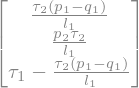

---

In [13]:
QQ_expr = delta_W.jacobian(ddelta_theta).T ##:

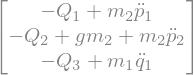

In [14]:
mod.eqns

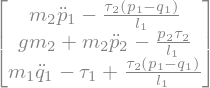

---

In [15]:
eqns = mod.eqns.subz(QQ, QQ_expr) ##:

## Flatness analysis

Do not forget to substitute $l_1 = \sqrt{(p_1 - q_1)^2 + p_2^2}$ !!!

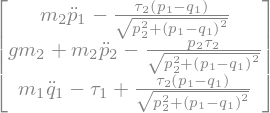

---

In [16]:
eqns_subs = eqns.subs(l1, sp.sqrt((rope.T*rope)[0])) ##:

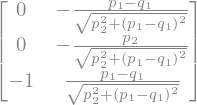

---

In [17]:
J3 = eqns_subs.jacobian(ttau) ##:

eliminate the 3rd equation and tau1 → 2 remaining equations

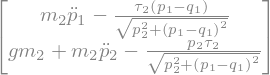

---

In [18]:
eqns1 = eqns_subs[:-1, :] ##:

the new Jacobi matrix wrt just $\tau_2$ as only remaining input is calculated

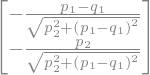

---

In [19]:
J2 = eqns1.jacobian([tau2]) ##:

This Jacobi Matrix has no column with just a single entry other than 0. So a Transformation with the left Orthocomplement $J_2^{L\perp}$ and the left pseudo-inverse $J_2^{L+}$ is applied:

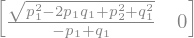

---

In [20]:
J2pinv = J2[:1, :].inverse_ADJ()
J2pinv = st.col_stack(J2pinv, sp.Matrix([0])) ##:

In [21]:
# check
tmp = (J2pinv * J2).smplf ##:


assert tmp == sp.eye(1)

---

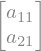

---

In [22]:
# nullspace(~kernel) (orthocomplement)
# A matrix in place represents B before substituting exact elements of B
A = st.symbMatrix(2, 1)##:

In [23]:
A_ortho = st.nullspaceMatrix(A.T).T ##:

---

In [24]:
(A.T * A_ortho.T).smplf

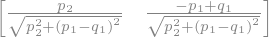

---

In [25]:
J2_ortho = A_ortho.subz(list(A), list(J2)).smplf ##:

In [26]:
# check orthocomplement property:
res = (J2_ortho * J2).smplf ##:
assert not any(res)

---

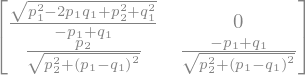

---

In [27]:
T = st.row_stack(J2pinv, J2_ortho) ##:

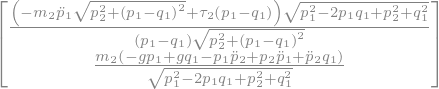

---

In [28]:
eqns2 = (T*eqns1).smplf ##:

In [29]:
J2T = eqns2.jacobian([tau2]).smplf ##:

---

So the first system equation can be eliminated as well as $\tau_2$, so the last remaining system equation will be used to determine the flat output $\mathbf{y}$:

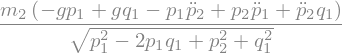

In [30]:
eqns2[-1]

In [31]:
eqns2[-1].s

## System parameterization by flat output

as $q_1$ is the only symbol not appearing as a derivative, it should be paramized with $q_1 = \varphi(p_1, \ddot{p_2}, p_2, \ddot{p_2})$ and the flat output is found as $\mathbf{y} = (p_1, p_2)^T$:

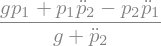

---

In [32]:
q1_flat = sp.solve(eqns2[-1], q1)[0] ##:

the first transformed system equation will be used together with substitution of $q_1$ for $\tau_2$:

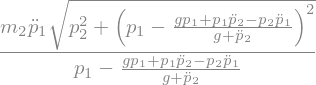

---

In [33]:
tau2_flat = sp.solve(eqns2[0], tau2)[0].subs(q1, q1_flat) ##:

a preliminary expression of $\tau_1$ still containing quantities not element of $\mathbf{y}$ can be found:

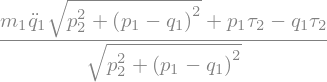

---

In [34]:
tau1_pre_flat = sp.solve(eqns_subs[-1], tau1)[0] ##:

so derivatives of $q_1$ are needed:

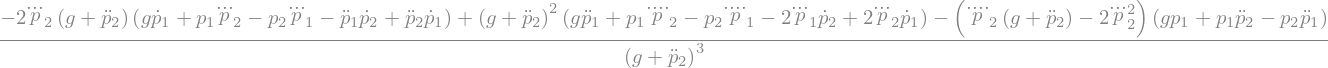

---

In [35]:
qddot1_flat = st.time_deriv(q1_flat, ttheta, order=2) 
qddot1_flat = qddot1_flat.smplf ##:

substituting this into the prior expression for $\tau_1$ leads to:

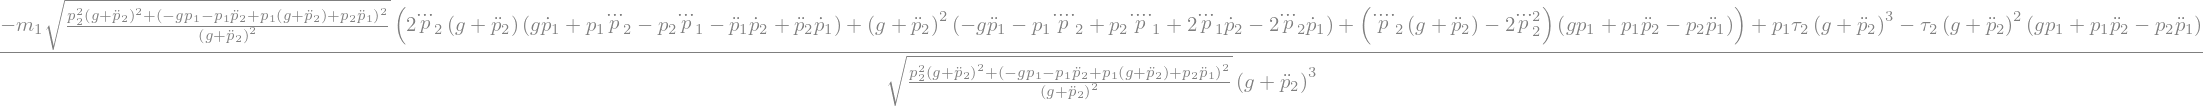

---

In [36]:
tau1_pre_flat = tau1_pre_flat.subz([q1, qddot1], [q1_flat, qddot1_flat]).smplf ##:

In [37]:
tau1_pre_flat.s

substitute flattened $\tau_2$ in expression of $\tau_1$

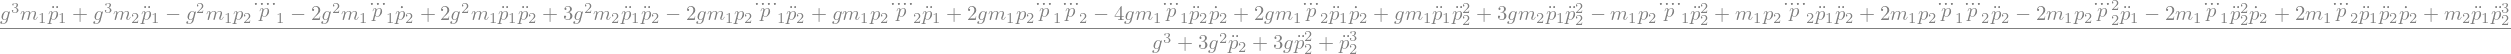

---

In [38]:
tau1_flat = tau1_pre_flat.subs(tau2, tau2_flat).smplf ##:

In [39]:
tau1_flat.s

In [44]:
# equations of motions generate LaTeX-Code for the video:
from symbtools import interactive_aux as ia
ia.adapted_latex(tau1_flat)

\frac{g^{3} m_{1} \ddot{p}_{1} + g^{3} m_{2} \ddot{p}_{1} - g^{2} m_{1} p_{2} \ddddot{p}_{1} - 2 g^{2} m_{1} \dddot{p}_{1} \dot{p}_{2} + 2 g^{2} m_{1} \ddot{p}_{1} \ddot{p}_{2} + 3 g^{2} m_{2} \ddot{p}_{1} \ddot{p}_{2} - 2 g m_{1} p_{2} \ddddot{p}_{1} \ddot{p}_{2} + g m_{1} p_{2} \ddddot{p}_{2} \ddot{p}_{1} + 2 g m_{1} p_{2} \dddot{p}_{1} \dddot{p}_{2} - 4 g m_{1} \dddot{p}_{1} \ddot{p}_{2} \dot{p}_{2} + 2 g m_{1} \dddot{p}_{2} \ddot{p}_{1} \dot{p}_{2} + g m_{1} \ddot{p}_{1} \ddot{p}_{2}^{2} + 3 g m_{2} \ddot{p}_{1} \ddot{p}_{2}^{2} - m_{1} p_{2} \ddddot{p}_{1} \ddot{p}_{2}^{2} + m_{1} p_{2} \ddddot{p}_{2} \ddot{p}_{1} \ddot{p}_{2} + 2 m_{1} p_{2} \dddot{p}_{1} \dddot{p}_{2} \ddot{p}_{2} - 2 m_{1} p_{2} \dddot{p}_{2}^{2} \ddot{p}_{1} - 2 m_{1} \dddot{p}_{1} \ddot{p}_{2}^{2} \dot{p}_{2} + 2 m_{1} \dddot{p}_{2} \ddot{p}_{1} \ddot{p}_{2} \dot{p}_{2} + m_{2} \ddot{p}_{1} \ddot{p}_{2}^{3}}{g^{3} + 3 g^{2} \ddot{p}_{2} + 3 g \ddot{p}_{2}^{2} + \ddot{p}_{2}^{3}}
% -------------


## Look on model and substitution of variable ropes

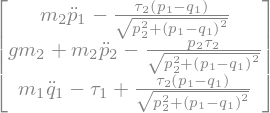

---

---

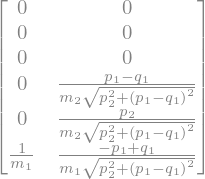

---

In [29]:
rope1 = S2 - S1
mod.eqns = eqns.subs(l1, sp.sqrt((rope1.T*rope1)[0])) ##:
mod.tau = ttau
mod.calc_state_eq(force_recalculation=True)
mod.f ##T:
mod.g ##:

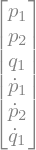

In [32]:
mod.xx

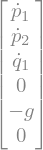

In [33]:
mod.f[]

In [30]:
pickle_model = {"mod":mod}

In [31]:
# store with pickle

with open("single_crane_model.pcl", "wb") as pfile:
    pickle.dump(pickle_model, pfile)